In [103]:
# ! pip install jugaad_data, nsetools
from jugaad_data.nse import stock_df
from nsetools import Nse

from datetime import date, datetime, timedelta
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as fplt
import plotly.graph_objects as go
from plotly import colors as plotly_colors

from multiprocessing import Pool

import requests
from bs4 import BeautifulSoup
import random

from os import listdir
from os.path import isfile, join

import json
import warnings
import math
from random import sample

In [110]:
# assert False 

def get_stocks(name):
    try:
        df = stock_df(symbol=name, from_date = current_date - timedelta(days = 465), to_date = current_date, series="EQ").drop(drop,axis=1)
        ID, NAME, _ = all_Stocks[name].split('_')
        save = f"./data/{ID}_{NAME}_{str(current_date)}.csv"
        df.to_csv(save,index=None)
    except Exception as e:
        print(e)
        pass
 
path = './data'
AS = AnalyseStocks()
all_stocks = {}
for key in AS.all_stocks:
    all_stocks[key] = AS.all_stocks[key].split('_')[0]

for f in listdir(path):
    if isfile(join(path, f)):
        split = f.split('_')[0]
        if split in all_stocks:
            del all_stocks[split]

drop = ['SERIES','PREV. CLOSE','VWAP','VOLUME','VALUE','NO OF TRADES']
current_date = date.today()
stocks = list(all_stocks.keys())
random.shuffle(stocks)


pool = Pool(3)
results = pool.map(get_stocks,stocks)
pool.close()
pool.join()

# Code

In [199]:
class DataHandler:
    def __init__(self, data_path = './data'):
        self.present = date.today()
        self.week_num = self.present.strftime("%W")
        
        self.data_path = data_path
        self.all_stocks = self.read_data()['all_stocks']
        self.data = self.read_data()
            
    
    def read_data(self, path = './', file = 'data.json'):
        '''
        Write the data in json file
        args:
            path: Path of the directory
            File: Json Filename
        '''
        with open(join(path,file)) as f:
            return json.load(f)


    def update_data(self, updated_data:dict, path:str = './', file:str = 'data.json'):
        '''
        Update the data in the json file
        args:
            updated_data: Dictonary you want to update
            path: Path of the directory
            File: Json Filename
        '''
        with open(join(path,file), 'w') as f:
            json.dump(updated_data,f)
            return True 
        
    
    def _update_eligible_stocks(self, fresh_stocks:dict):
        '''
        Update the new data of this week
        args:
            fresh_stocks: Newest stocks of this week
        '''
        self.data['eligible_stocks'] = {} # delete old eligible stocks
        self.data['eligible_stocks'][self.week_num] = fresh_stocks
        self.update_data(self.data)
        return True
    
    
    def open_live_stock_data(self,name:str):
        '''
        Open the fresh stock from the market
        args:
            name: ID of the stock given
        '''
        drop = ['SERIES','PREV. CLOSE','VWAP','VOLUME','VALUE','NO OF TRADES']
        return stock_df(symbol=name, from_date = self.present - timedelta(days = 465), to_date = self.present, series="EQ").drop(drop,axis=1)
    
    
    def open_downloaded_stock(self,name:str):
        '''
        Open the Individual stock based on it's Official Term
        args:
            name: Name / ID given to the stock. Example, Infosys is "INFY"
        returns: DataFrame of that stock
        '''
        return pd.read_csv(join(self.data_path,self.all_stocks[name]))

In [206]:
class AnalyseStocks(DataHandler):
    def __init__(self):
        '''
        args:
            path: Path where all the stock files are saved
        '''
        super().__init__()
        self.eligible = {}
        self.registered_stocks = self.read_data()['registered_stocks']
        self.colors = self.read_data()['colors']
    

    def is_eligible(self, df, mv = 44, names:tuple = ('DATE','OPEN','CLOSE','LOW','HIGH')):
        '''
        Find the Positive Stocks which are about to rise on the Moving average line
        args:
            df: DataFrame
            mv: Moving Average to Consider
            names: Tuple of column names showing ('DATE','OPEN','CLOSE','LOW','HIGH')
        '''
        Date, Open, Close, Low, High = names
        Average = f'{str(mv)}-SMA'
        
        stocks = df.sort_index(ascending=False,) # Sort the values else Moving average for new values will be empty
        stocks[Average] = stocks[Close].rolling(mv, min_periods = 1).mean()
        
        last_traded = stocks.iloc[-1,:]
        if (last_traded[Close] > last_traded[Open]) and (last_traded[Close] > last_traded[Average]) and (0 <= (last_traded[Low] - last_traded[Average]) <= last_traded[Close] - last_traded[Open]):
            return {last_traded['SYMBOL'] : round(last_traded[Low] - last_traded[Average],2)}

        return False
    
    
    def update_eligible(self):
        '''
        Save all Eligible stocks for the current week
        '''
        for key in self.all_stocks.keys():
            result = self.is_eligible(self.open_downloaded_stock(key))
            if result:
                self.eligible.update(result)
        self._update_eligible_stocks({k: v for k, v in sorted(self.eligible.items(), key=lambda item: item[1])})
        return self.eligible
            
    
    def plot_candlesticks(self,df, names = ('DATE','OPEN','CLOSE','LOW','HIGH'), mv:list = [44,100,200]):
        '''
        Plot a candlestick on a given dataframe
        args:
            df: DataFrame
            names: Tuple of column names showing ('DATE','OPEN','CLOSE','LOW','HIGH')
            mv: Moving Averages
        '''
        stocks = df.copy()
        Date, Open, Close, Low, High = names
        colors = sample(self.colors,len(mv))
        stocks.sort_index(ascending=False, inplace = True)  # Without reverse, recent rolling mean will be either NaN or equal to the exact value
    

        candle = go.Figure(data = [go.Candlestick(x = stocks[Date], name = 'Trade',
                                                       open = stocks[Open], 
                                                       high = stocks[High], 
                                                       low = stocks[Low], 
                                                       close = stocks[Close]),])
        for i in range(len(mv)):
            stocks[f'{str(mv[i])}-SMA'] = stocks[Close].rolling(mv[i], min_periods = 1).mean()
            candle.add_trace(go.Scatter(name=f'{str(mv[i])} MA',x=stocks[Date], y=stocks[f'{str(mv[i])}-SMA'], 
                                             line=dict(color=colors[i], width=1.1)))

        candle.update_xaxes(
            title_text = 'Date',
            rangeslider_visible = True,
            rangeselector = dict(
                buttons = list([
                    dict(count = 1, label = '1M', step = 'month', stepmode = 'backward'),
                    dict(count = 6, label = '6M', step = 'month', stepmode = 'backward'),
                    dict(count = 1, label = 'YTD', step = 'year', stepmode = 'todate'),
                    dict(count = 1, label = '1Y', step = 'year', stepmode = 'backward'),
                    dict(step = 'all')])))

        candle.update_layout(autosize = False, width = 1400, height = 600,
                             title = {'text': f"{stocks['SYMBOL'][0]} | {self.all_stocks[stocks['SYMBOL'][0]]}",'y':0.97,'x':0.5,
                                      'xanchor': 'center','yanchor': 'top'},
                             margin=dict(l=30,r=30,b=30,t=30,pad=2),
                             paper_bgcolor="lightsteelblue",)

        candle.update_yaxes(title_text = 'Price in Rupees', tickprefix = u"\u20B9" ) # Rupee symbol
        candle.show()

# Investing

In [207]:
class Investing(AnalyseStocks):
    def __init__(self,rolling_mean:int=44):
        '''
        args:
            rolling_mean: Rolling Simple Mean to calulate
        '''
        super().__init__()
        self._is_fresh_data_()
        
        self.rm = rolling_mean
        
        self._eligible = self.data['eligible_stocks'].get(self.week_num)
        if not self._eligible:
            self._eligible = self.update_eligible()
    
    
    def _is_fresh_data_(self):
        '''
        Check whether the data files we have are old or new
        '''
        files = listdir(self.data_path)
        w_el = list(self.data['eligible_stocks'].keys())[0]
        date_f = datetime.fromisoformat(files[0].split('.')[0].split('_')[-1])
        w_f = date_f.strftime("%W")
            
        if not len(files):
            raise Exception(f"No CSV data files present at {self.data_path} Download new data for analysis")
        
        else:
            if w_f < self.week_num:
                raise Exception(f"Week Mismatch. Data for week {w_f} present instead of {self.week_num}. Download new data for analysis")
            else:
                for file in files:
                    key, _ , _ = file.split('_')
                    self.data['all_stocks'][key] = file
                self.update_data(self.data)
        
        if w_el != self.week_num:
            self._update_eligible_stocks({}) # delete eligible stocks for existing week and update
            raise Exception(f"ELIGIBLE Data Week Mismatch. Data for week {w_el} present instead of {self.week_num}. Deleting Old Eligible. Update Eligible")
           
    
    def pick(self,budget, High = 'HIGH', Close = 'CLOSE', delta:float=0.01, nifty:str = 'nifty_500'):
        '''
        Pick Stocks based on all available and which are within your budget
        args:
            budget: Total available budget. Stocks under this budget will be considered only
            High: Column name which show High
            Close: Column Name which shows last closing price
            delta: Value above the Last Highest Traded Price
            nifty: nifty index to consider
        ''' 
        keys = set(self._eligible.keys()).intersection(set(self.data[nifty])) if nifty else list(self._eligible.keys()) 
        values = []
        for key in keys:
            df = self.open_downloaded_stock(key)
            if df.loc[0,High] + delta > budget or df.loc[0,Close] < 50:
                del self._eligible[key]
                
            else:
                values.append(df.iloc[0,:])
                
        df = pd.DataFrame(values,columns=df.columns,index = range(len(values)))
        df = df.merge(pd.DataFrame({'SYMBOL':self._eligible.keys(), 'Diff':self._eligible.values()}),on='SYMBOL')
        self.picked = df.sort_values('Diff',ascending = True)
        return self.picked
    
    
    def show_particulars(self, df, budget:float, max_loss_capacity:float, risk_to_reward_ratio:float=2, Low:str = 'LOW', High:str = 'HIGH', delta:float = 0.3, plot_candle:bool = False):
        '''
        Display the particulars of a trade before buying
        args:
            df: DtaFrame of a particular stock
            loss_capacity: How much loss you can survive at the end of day PER SHARE. Total capacity will be No of shares * per share loss capacity
            risk_to_reward_ratio: How much profit you want to have. It is twice of loss_capacity per share for 44 Moving average
            budget : How much you have for investing purpose
            Low: Column name which describes LOW of the previous trade
            High =  Column name which describes High of the previous trade
            delta: A min amount above which you'll buy
            plot_candle: Plot the candlestick for the stock
        '''
        if risk_to_reward_ratio > 2:
            warnings.warn(f"Don't be greedy with risk to reward ratio of {risk_to_reward_ratio}. Stick to system")
            
        if max_loss_capacity > 0.10 * budget:
            warnings.warn(f"You are risking {round(max_loss_capacity/budget,2)*100}% of your total budget. Try keeping it less than 10% @ Rs{round(budget/10,2)}")
            
        risk = max_loss_capacity # per share
        entry = df.loc[0,High] + delta # Last Day MAX + Delta
        stop_loss = min(df.loc[:2,Low].values) # Min of the last 2 
        max_loss = entry - stop_loss
        stop_loss_perc = round((max_loss / entry) *100,2)
        diff = entry - stop_loss
        quantity = int((risk / diff))
        profit = risk_to_reward_ratio * diff
        profit_perc = round((profit/entry)*100,2)
        target = round(entry + profit,2)
        
        
        if plot_candle:
            AnalyseStocks().plot_candlesticks(df)
         
        if budget < quantity * entry:
            warnings.warn(f"You dont not have budget to buy {quantity} shares. You can buy a max of {budget // entry} shares. Increase Budget")
            quantity = min(budget // entry, quantity)
            
        if budget < entry:
            warnings.warn(f"Budget for this stock should be a minimum of Rs. {entry}")
            return None
        
        if quantity < 1:
            r = round(risk + (diff - risk), 2)
            warnings.warn(f"Risk should be atleast {r} for you to afford for this stock")
            return None
            
        return {'Buying Price':entry,'Stop-Loss %': stop_loss_perc,'Target %':profit_perc,'Quantity':quantity,'Stop-Loss Price':stop_loss,'Trigger Price':target,
                'Max Gain Per Share':round(profit,2),'Total Max Loss':round(quantity*diff,2),'Total Max Gain': round(quantity*profit,2), 'Remaining Balance':round(budget - (quantity *entry),2)}

In [209]:
In = Investing()
In.pick(10000)

,DATE,OPEN,HIGH,LOW,LTP,CLOSE,52W H,52W L,SYMBOL,Diff
2,2021-07-16,207.70,209.65,207.20,207.85,207.90,239.20,163.35,ITC,0.20
13,2021-07-16,312.40,335.90,310.30,334.00,333.35,345.00,171.00,ORIENTELEC,2.00
1,2021-07-16,566.10,573.95,566.00,570.00,569.25,719.90,273.20,DBL,2.88
8,2021-07-16,655.00,671.60,654.45,662.00,662.35,898.90,522.00,IOLCP,5.68
4,2021-07-16,291.30,307.20,285.05,303.25,303.45,336.50,92.30,SEQUENT,8.47
11,2021-07-16,320.50,340.00,317.00,336.00,337.30,342.10,177.40,GSPL,9.45
9,2021-07-16,655.85,690.00,655.85,685.30,687.05,690.00,405.00,GLENMARK,20.42
10,2021-07-16,1047.00,1090.00,1044.00,1076.00,1077.65,1231.90,562.20,HAVELLS,22.32
3,2021-07-16,1545.00,1582.50,1537.20,1580.00,1577.35,1807.50,1376.00,GLAXO,24.11
7,2021-07-16,1400.00,1457.85,1394.50,1446.10,1447.90,1498.95,897.00,UBL,26.74


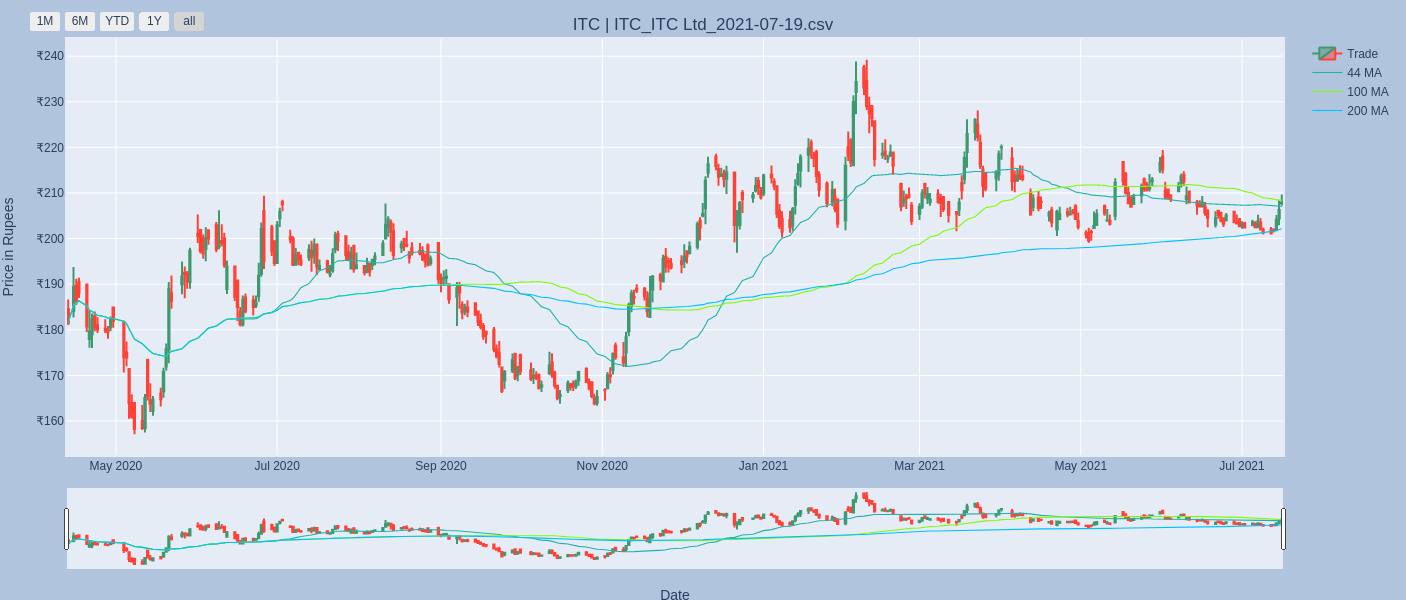

{'Buying Price': 209.95000000000002,
 'Stop-Loss %': 3.93,
 'Target %': 7.86,
 'Quantity': 6,
 'Stop-Loss Price': 201.7,
 'Trigger Price': 226.45,
 'Max Gain Per Share': 16.5,
 'Total Max Loss': 49.5,
 'Total Max Gain': 99.0,
 'Remaining Balance': 1240.3}

In [211]:
df = In.open_downloaded_stock('ITC')
In.show_particulars(df, 2500, 50, plot_candle=True)